You can find a copy of this tutorial as a Jupyter notebook here or download it by right clicking here and selecting "Save Link As".

# Modifying the default values for surface error and aperture efficiency.

We encourage users of the GBT to rely on the Observatory-measured values and functions for surface error and aperture efficiency, which are implemented in `dysh`.   However, advanced users may wish to modify the values or functions; this example shows how to do that.


## Refresher on aperture efficiency and brightness scales
The aperture efficiency $\eta_a$ is determined by:

$$\eta_a = \eta_0~G(ZD) \exp(-(4\pi\epsilon/\lambda)^2),$$

where $\eta_0$ is the long wavelength aperture efficiency, $G(ZD)$ is the gain correction factor
at a zenith distance $ZD$, $\epsilon$ is the surface error, and $\lambda$ is the wavelength.

To scale antenna temperature $T_a$ to brightness tempeature $T_a^*$:

$$ T_a^* = T_a~\exp(\tau~A)/(\eta_a~\eta_l),$$

where $\tau$ is the zenith opacity, $A$ is the airmass, and $\eta_l$ is the loss efficiency.  To scale to flux $S_\nu$

$$ S_\nu = 2~k~T_a^*/A_p, $$

where $k$ is Boltzmann's constant is $A_p$ is the physical aperture of the telescope. 




## What `dysh` does

When you calibrate and scale data through, e.g. `GBTFITSLoad.getps`, `dysh` uses the `GBTGainCorrection` class to manage the calculations described above. `GBTGainCorrection` maintains $G(ZD)$ and surface error as a function of date as derived in [GBT Memo 301](https://library.nrao.edu/public/memos/gbt/GBT_301.pdf). You can provide your own values for $\eta_a$ or $\epsilon$ in the standard calibration routines. (You must provide $\tau$).


## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [26]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
import numpy as np

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [27]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [28]:
sdfits = GBTFITSLoad(filename)

/home/mpound/.local/share/hatch/env/virtual/dysh/oijlXzrC/dysh/lib/python3.11/site-packages/astropy/io/fits/header.py:541: ResourceWarning: unclosed <socket.socket fd=69, family=2, type=1, proto=6, laddr=('192.168.0.84', 44456), raddr=('192.33.116.7', 80)>
  header._keyword_indices[keyword].append(idx)


In [29]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction
We calibrate a few scans of the position switched observations, giving a value for `zenith_opacity` but leaving `dysh` to calculate aperture efficiency.

In [30]:
ps_scan_block = sdfits.getps(scan=[51,53,55], ifnum=0, plnum=0, fdnum=0, units="flux", zenith_opacity=0.08)

#### Those same scans but modifying aperture efficiency

In [31]:
ps_scan_block2 = sdfits.getps(scan=[51,53,55], ifnum=0, plnum=0, fdnum=0, units="flux", zenith_opacity=0.08, ap_eff=0.25)

#### Those same scans but modifying surface_error. 
(You can't give both surface error and aperture efficiency because the latter is computed from the former.)

In [50]:
ps_scan_block3 = sdfits.getps(scan=[51,53,55], ifnum=0, plnum=0, fdnum=0, units="flux", zenith_opacity=0.08, surface_error=400*u.micron)

#### Print the different $\eta_a$ for the first scan in each ScanBlock.  
#### You can see that at this wavelength , the surface error does not have much of an effect because $\epsilon << \lambda$. (400 $\mu$m vs. 21 cm)

In [51]:
print(f"{np.mean(ps_scan_block[0].ap_eff):.4f},{np.mean(ps_scan_block2[0].ap_eff):.4f},{np.mean(ps_scan_block3[0].ap_eff):.4f}")

0.7047,0.2500,0.7045


#### But the aperture efficiency does make a different in the derived flux

S_nu = 0.18 Jy


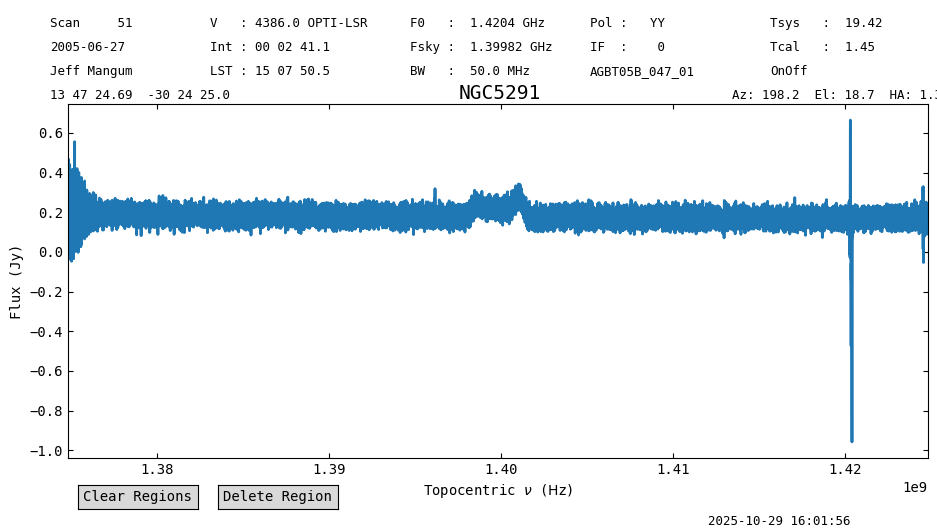

In [63]:
a=ps_scan_block.timeaverage()
print(f"S_nu = {np.median(a.flux):.3}")
a.plot()

S_nu = 0.508 Jy


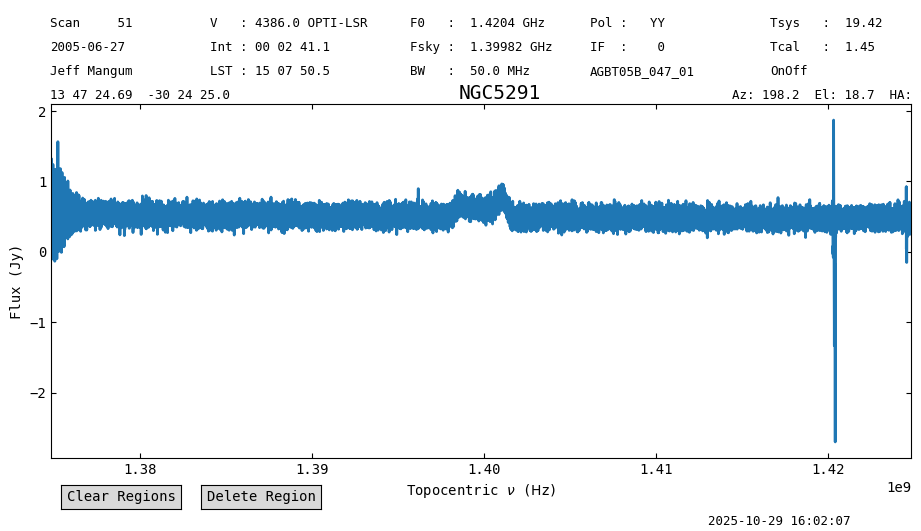

In [64]:
b=ps_scan_block2.timeaverage()
print(f"S_nu = {np.median(b.flux):.3}")
b.plot()

#### The weighted average aperture efficiency, surface error, and zenith opacity are stored in the spectrum metadata.

In [71]:
print(f"eta = {a.meta['AP_EFF']:.3f}, epsilon = {a.meta['SURF_ERR']:.1f} {a.meta['SE_UNIT']}, tau = {a.meta['TAU_Z']:.2f}")

eta = 0.705, epsilon = 230.0 micron, tau = 0.08


### What if I want to change $G(ZD)$ or the surface error model?
This is advanced usage and requires you to fork or clone dysh, then modify `src/dysh/data/gaincorrection.tab`. If you have questions, consult with a `dysh` developer. 